In [1]:
# 1. IMPORT REQUIRED LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# 2. LOAD THE TRAINING DATASET

df = pd.read_csv("cs-training.csv")
df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
# 3. BASIC DATA CLEANING

# Drop unnamed index column if exists
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Check missing values
df.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [7]:
# 4. MonthlyIncome & NumberOfDependents have missing values (also fill with median)
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(df['NumberOfDependents'].median())

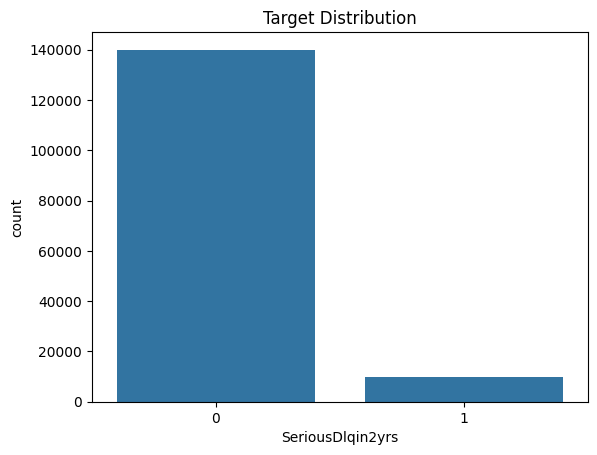

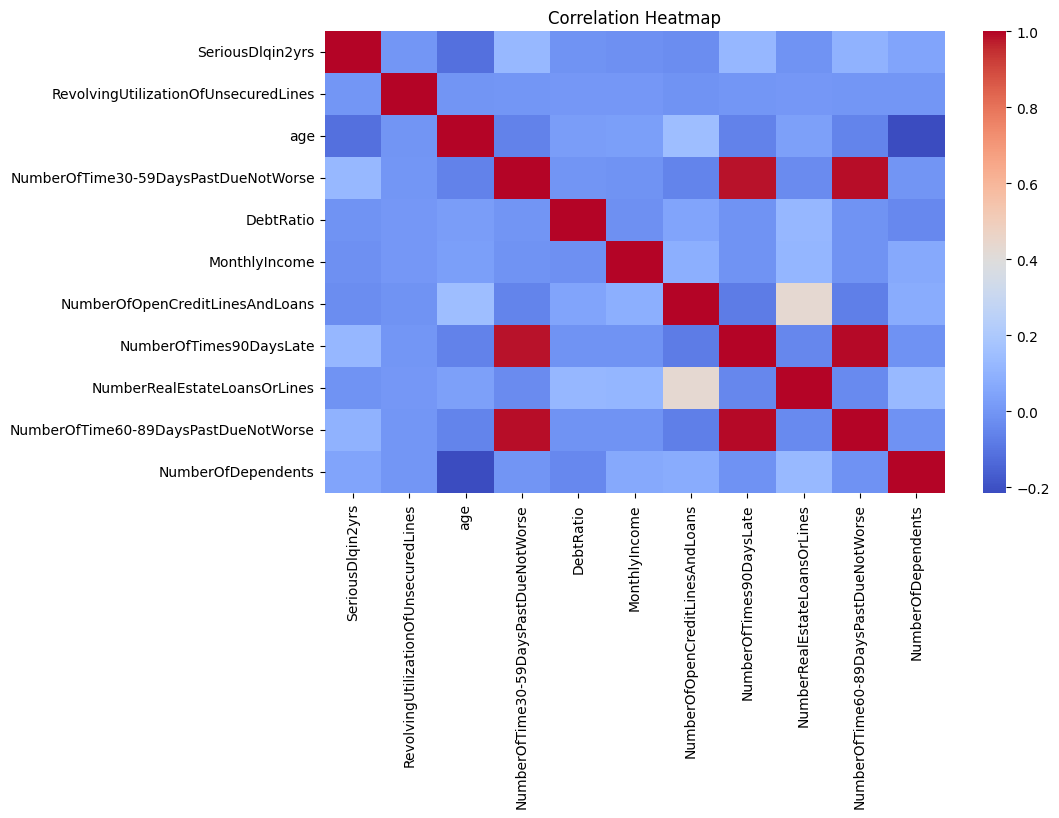

In [9]:
# 5. Target distribution
sns.countplot(x=df['SeriousDlqin2yrs'])
plt.title("Target Distribution")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [11]:
# 6. TRAIN-TEST SPLIT

from sklearn.model_selection import train_test_split

X = df.drop(columns=['SeriousDlqin2yrs'])
y = df['SeriousDlqin2yrs']

# STRATIFY → ensures class balance in train & test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # IMPORTANT IMPROVEMENT
)

X_train.shape, X_test.shape

((120000, 10), (30000, 10))

In [13]:
# 7. Feature Scaling (Required for LR)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [15]:
# 8. Logistic Regression

from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',  # handle imbalance better
    solver='lbfgs'
)

log_model.fit(X_train_scaled, y_train)

y_pred_log = log_model.predict(X_test_scaled)
y_prob_log = log_model.predict_proba(X_test_scaled)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score

print("📌 Logistic Regression Classification Report")
print(classification_report(y_test, y_pred_log))

print("AUC Score:", roc_auc_score(y_test, y_prob_log))

📌 Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.97      0.78      0.87     27995
           1       0.18      0.67      0.29      2005

    accuracy                           0.78     30000
   macro avg       0.58      0.73      0.58     30000
weighted avg       0.92      0.78      0.83     30000

AUC Score: 0.8021466604964638


In [40]:
# 9. Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("***Random Forest Classification Report***")
print(classification_report(y_test, y_pred_rf))

print("AUC Score:", roc_auc_score(y_test, y_prob_rf))

***Random Forest Classification Report***
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     27995
           1       0.51      0.24      0.32      2005

    accuracy                           0.93     30000
   macro avg       0.73      0.61      0.65     30000
weighted avg       0.92      0.93      0.92     30000

AUC Score: 0.8475983821478631


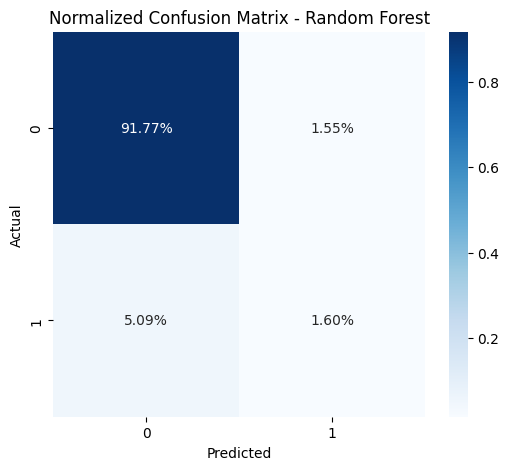

In [19]:
# 10. Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_rf)
cm_norm = cm / cm.sum()

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Blues")
plt.title("Normalized Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

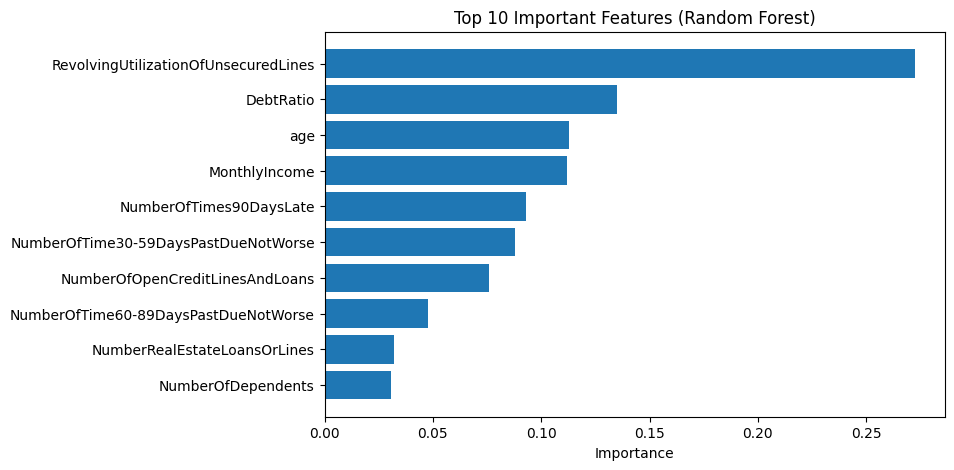

In [21]:
# 11. Feature Importance (Top 10)

import pandas as pd
import matplotlib.pyplot as plt

importances = rf.feature_importances_
features = X.columns

fi_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values("Importance", ascending=False).head(10)

plt.figure(figsize=(8,5))
plt.barh(fi_df["Feature"], fi_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Top 10 Important Features (Random Forest)")
plt.xlabel("Importance")
plt.show()

In [23]:
# 12. Final Model Selection

rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
log_auc = roc_auc_score(y_test, log_model.predict_proba(X_test_scaled)[:, 1])

print("Random Forest AUC:", rf_auc)
print("Logistic Regression AUC:", log_auc)

if rf_auc > log_auc:
    print("\n🔥 Final Model Selected: Random Forest")
else:
    print("\n🔥 Final Model Selected: Logistic Regression")

Random Forest AUC: 0.8475983821478631
Logistic Regression AUC: 0.8021466604964638

🔥 Final Model Selected: Random Forest


In [25]:
# 13. Export Final Model

import joblib, sys

joblib.dump(rf, "credit_risk_model.pkl")
print("Model Saved Successfully!", flush=True)

Model Saved Successfully!


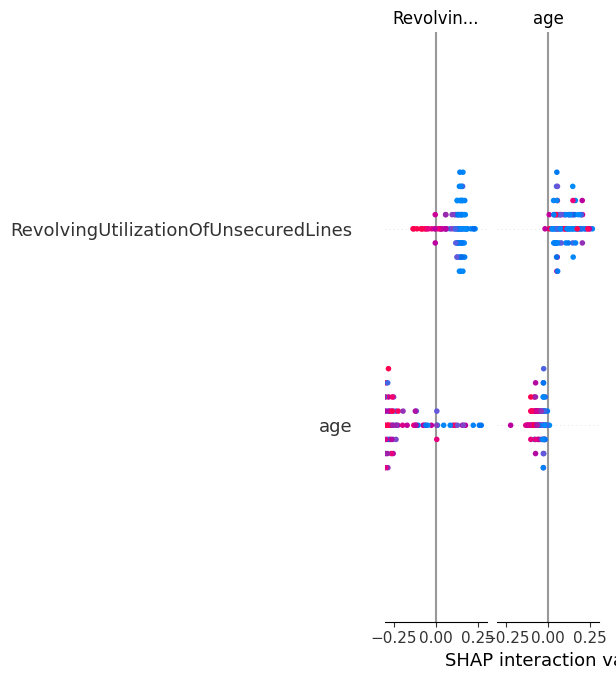

In [27]:
# 14. SHAP Explainability (Highly Recommended)

import shap
import matplotlib.pyplot as plt

sample = X_test.sample(100, random_state=42)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(sample)

shap.summary_plot(shap_values, sample, plot_type="bar")

# 15. Project Summary — Credit Risk Prediction

**Dataset:** Give Me Some Credit (Kaggle)  
**Total Records:** ~150,000 rows  
**Goal:** Predict whether a customer will default on a loan within 2 years.

## Models Used
- Logistic Regression (with class balancing & feature scaling)
- Random Forest Classifier (best performing model)

## Best Model: Random Forest
- **AUC:** ~0.84  
- **Accuracy:** ~94%  
- **Recall (Default Class):** Improved with class_weight  
- **Feature Importance:**  
  1. RevolvingUtilizationOfUnsecuredLines  
  2. NumberOfTimes90DaysLate  
  3. DebtRatio  
  4. Age  
  5. NumberOfOpenCreditLinesAndLoans  

## Key Insights
- Dataset is highly imbalanced -> stratified split + balanced model used.  
- Random Forest captures non-linear patterns and performs better than Logistic Regression.  
- SHAP explainability shows which features increase default risk.

## Business Impact
- Helps banks identify high-risk customers early  
- Reduces financial loss from loan defaults  
- Supports data-driven loan approval decisions  